<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/temp/9x.ml_highspeed_networks/1.Training-and-testing-a-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pickle # To save the model



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


import os
from os.path import isfile

--2020-05-23 16:36:48--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py.2’

visualization.py.2  100%[===================>]  12.70K  --.-KB/s    in 0s      

2020-05-23 16:36:48 (76.7 MB/s) - ‘visualization.py.2’ saved [13008/13008]



# Download the dataset and train/test split

Load the dataset

In [ ]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2020-05-23 16:35:26--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.04s   

2020-05-23 16:35:26 (5.71 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2020-05-23 16:35:27--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connec

In [ ]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time"])

data = full_df.to_numpy()
print (data)

[[1.83684800e+06 1.90327023e+08 1.16151881e+08 ... 2.59473178e+08
  1.00265909e+02 0.00000000e+00]
 [1.85564100e+06 1.90782590e+08 1.16159726e+08 ... 2.59522865e+08
  1.00276024e+02 0.00000000e+00]
 [1.85637300e+06 1.90688064e+08 1.16229597e+08 ... 2.59533231e+08
  1.00281822e+02 0.00000000e+00]
 ...
 [4.63221500e+06 1.75145145e+08 9.35510160e+07 ... 2.59453245e+08
  1.00262788e+02 2.00000000e+00]
 [4.64478900e+06 1.75105471e+08 9.33248380e+07 ... 2.59444187e+08
  1.00259509e+02 2.00000000e+00]
 [4.63646600e+06 1.75154689e+08 9.35143800e+07 ... 2.59458785e+08
  1.00264199e+02 2.00000000e+00]]


In [ ]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,branches,bus-cycles,cache-misses,cache-references,context-switches,cpu-clock,cycles,dTLB-load-misses,dTLB-store-misses,dTLB-stores,iTLB-load-misses,iTLB-loads,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,105852681.0,9979685.0,597.0,450842.0,0.0,100.265610,259323485.0,1930.0,1003.0,116268401.0,2595.0,8.0,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,259473178.0,100.265909,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,105824138.0,9979835.0,602.0,454711.0,0.0,100.276363,259527811.0,1968.0,1028.0,116231409.0,2557.0,0.0,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,259522865.0,100.276024,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,105932173.0,9980286.0,657.0,451996.0,0.0,100.282061,259493612.0,1981.0,1040.0,116288889.0,2595.0,8.0,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,259533231.0,100.281822,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,105974902.0,9983166.0,1374.0,454628.0,0.0,100.269016,259464166.0,2031.0,1015.0,116218953.0,2645.0,0.0,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,259571508.0,100.270504,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,105931477.0,9978938.0,1325.0,452995.0,0.0,100.271755,259535337.0,2018.0,978.0,116317169.0,2914.0,0.0,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,259490859.0,100.270495,0


In [ ]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 32)
Possible labels  [0 1 2]


In [ ]:
def train_validation_test_splits(data, train_size, validation_size):
    assert(train_size + validation_size < 1.0)
    # shuffling of the dataset
    np.random.shuffle(data)
    # extract the training portion
    n = int(train_size * len(data))
    train, rest = data[:n,:], data[n:,:]
    # from the remaining examples, we extract the validation and test portions
    n = int(validation_size * len(data))
    validation, test = rest[:n,:], rest[n:,:]
    return train, validation, test

train, validation, test = train_validation_test_splits(data, 0.8, 0.1)

print('The number of examples in the original dataset is ' + str(data.shape[0]))

print('The training-set has ' + str(train.shape[0]) + ' examples')
print('The validation-set has ' + str(validation.shape[0]) + ' exampels')
print('The test-set has ' + str(test.shape[0]) + ' examples')
print('The shape of train is ' + str(train.shape)) 

The number of examples in the original dataset is 5824
The training-set has 4659 examples
The validation-set has 582 exampels
The test-set has 583 examples
The shape of train is (4659, 32)


# Pre-processing

In [ ]:
# We separate the last column in 
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

validation_x, validation_y = np.hsplit(validation, [validation.shape[1] - 1])
validation_y = validation_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [ ]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
validation_x = (validation_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [ ]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Logistic Regression

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.23857868 0.71573604 0.04568528]
 [0.08715596 0.19266055 0.72018349]]
The accuracy is  0.7993138936535163


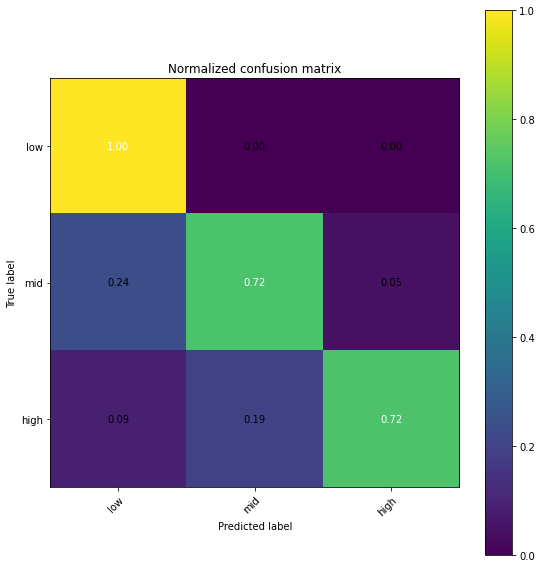

In [ ]:
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=600)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
class_names = np.array(["low", "mid", "high"] )
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

Save the model

In [ ]:
with open(my_path+"logistic-reg.pkl", "wb") as dump_file:
  pickle.dump(model, dump_file)

# 1st Neural Network

If you use Neural Networks, in Colab do "Runtime > Change Runtime type" to TPU or GPU.

The functions `build_model()` and `train_model(..)` are very similar to what you encountered in the [notebooks on Neural Networks](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [ ]:
def build_model():
  num_of_classes = 3

  model = Sequential([
    Dense(20, input_dim=train_x.shape[1], activation='relu' ),
    Dense(10, activation='relu' ),
    Dense(5, activation='relu' ),
    Dense(num_of_classes, activation="softmax")
  ])



  # sparse_categorical_crossentropy is meant to work when the target is 
  # encoded as an ordinal categorical quantity, as in our case when we have
  # 0, 1 and 2.
  # If you had a one-hot encoded target, you would have used 
  # categorical_cross_entropy instead
  model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

  return model



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 20)                640       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 18        
Total params: 923
Trainable params: 923
Non-trainable params: 0
_________________________________________________________________


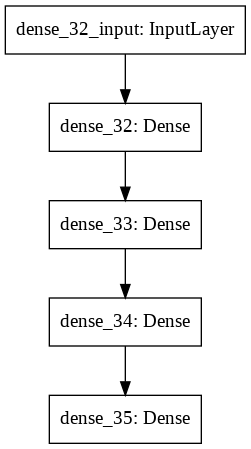

In [ ]:
model = build_model()
model.summary()
plot_model(model)

In [ ]:
def train_model(nn_file, X_tr, y_tr, epochs, overwrite=False):
  """
  nn_file:  Before training, the model contained in this file will be loaded
            After training, the resulting model will be written in this file

  
  overwrite: If true, the model will be built and trained from scratch
  """
  
  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/



  if overwrite==True:
    os.remove(nn_file)
    os.remove(nn_file+'.csv')


  if not isfile(nn_file):
    model = build_model()
  else:
    model = load_model(nn_file)

  history = model.fit(X_tr, y_tr, epochs=epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb], 
                      validation_split=0.2 )

  return model

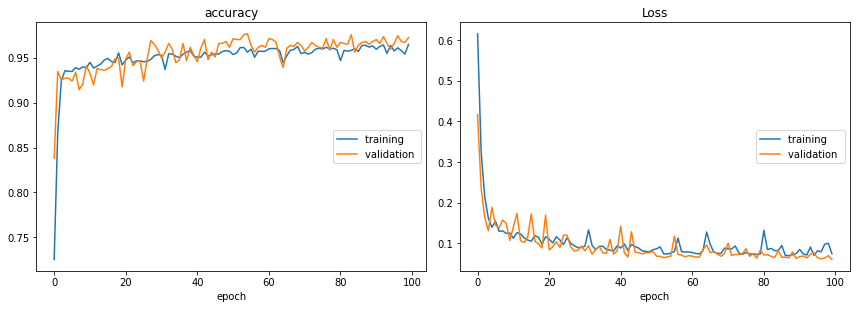

accuracy
	training         	 (min:    0.726, max:    0.965, cur:    0.965)
	validation       	 (min:    0.838, max:    0.976, cur:    0.972)
Loss
	training         	 (min:    0.070, max:    0.615, cur:    0.074)
	validation       	 (min:    0.060, max:    0.416, cur:    0.060)
117/117 [==============================] - 1s 5ms/step - loss: 0.0745 - accuracy: 0.9646 - val_loss: 0.0602 - val_accuracy: 0.9721


In [ ]:
nnfile = nn_file = my_path + 'nn1.h5'
model = train_model(nn_file, train_x, train_y, epochs=100)

In [ ]:
print("The trained NN model has been saved to ", nnfile)

The trained NN model has been saved to  /content/gdrive/My Drive/tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/nn1.h5


Normalized confusion matrix
[[0.96067416 0.         0.03932584]
 [0.00970874 0.94174757 0.04854369]
 [0.01507538 0.01005025 0.97487437]]
The accuracy is  0.9588336192109777


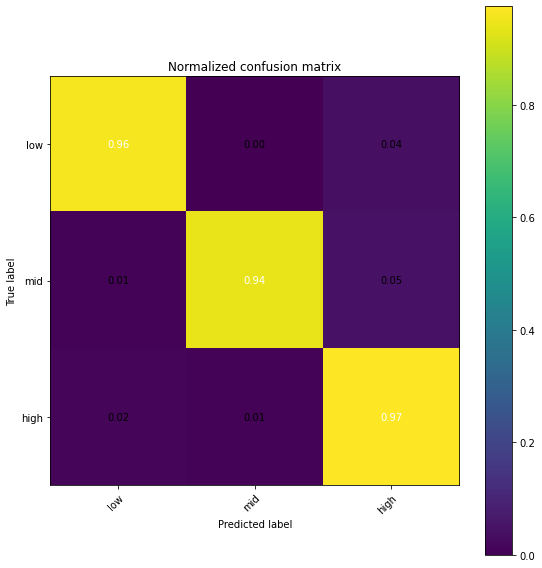

In [ ]:
y_pred = model.predict_classes(test_x)
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

This NN performs better than the Logistic Regression. However, will it be fast enough to classify at line speed?

You will have to check on the testbed notebook!

# Your model

Train your models here and dump (i.e., save) them.